# Manning liveProject: Deploy DL Model on Web & Mobile Using TensorFlow
---
## Milestone 1: Build an image classifier
* ResNet50
* MobileNetV2
* MobileNetV2: fine-tuned

## Solutions Notebook
---
#### Date updated:  20-Sep-2021
#### Author:  Nidhin Pattaniyil & Reshama Shaikh


In [1]:
from datetime import date
from datetime import datetime

current_date = date.today()
print("Today's date:", current_date)

Today's date: 2021-10-09


In [2]:
now1 = datetime.now()

start_time = now1.strftime("%H:%M:%S")
print("Start Time =", start_time)

Start Time = 17:09:24


In [3]:
# run this once (each session) if `watermark` library is not loaded, then comment out
#!pip install watermark tensorflow==2.3.*

In [4]:
# import libraries
#import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from pprint import pprint


In [5]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
import tensorflow as tf
import pathlib
import tensorflow_hub as hub

2021-10-09 17:09:24.402682: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [7]:
import watermark
%load_ext watermark
#%reload_ext watermark

In [8]:
# see version of system, python and libraries
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.27.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.0-1053-gcp
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

Git hash: 

numpy         : 1.19.5
tensorflow_hub: 0.9.0
tensorflow    : 2.3.4
watermark     : 2.2.0
requests      : 2.25.1
json          : 2.0.9
PIL           : 8.3.2
matplotlib    : 3.4.3
IPython       : 7.27.0



fatal: not a git repository (or any parent up to mount point /home)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [9]:
tf.__version__


'2.3.4'

# Running GPU on Colab
Ensure that GPU is running on this Colab notebook by following below steps.
1. Colab Menu: Select "Runtime"
2. "Change runtime type"
3. Select "Hardware Accelerator" = GPU
4. Save

In [10]:
# confirm that GPU is running
gpus = tf.config.list_physical_devices('GPU')
gpus

2021-10-09 17:09:25.809429: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-09 17:09:29.295142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:09:29.296745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-10-09 17:09:29.296870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:09:29.298656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:00:05.0 name

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

7:09:29.298757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:09:29.300316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:00:06.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-10-09 17:09:29.300393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:09:29.301985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 3 with properties: 
pciBusID: 0000:00:07.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-10-09 17:09:29.3020

In [11]:
tf.test.gpu_device_name()

2021-10-09 17:09:29.532449: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2021-10-09 17:09:29.533251: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556880bcf3d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-09 17:09:29.533286: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-09 17:09:30.226988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:09:30.235779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:09:30.241450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from Sys

'/device:GPU:0'

0.249505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:09:30.250726: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556882798ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-10-09 17:09:30.250757: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2021-10-09 17:09:30.250763: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2021-10-09 17:09:30.250769: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2021-10-09 17:09:30.250773: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5
2021-10-09 17:09:30.255243: I tensorflow/stre

# Setup Project Folder

In [12]:
!pwd

/home/jupyter/projects/food


In [13]:
!ls -lF

total 876
-rw-r--r-- 1 jupyter jupyter  68476 Oct  1 23:03 2021_09_20_1_run_dl_model_101_classes.ipynb
-rw-r--r-- 1 jupyter jupyter 162233 Oct  9 15:50 inference.ipynb
-rw-r--r-- 1 jupyter jupyter 548548 Oct  9 15:37 only_mobilenet.ipynb
drwxr-xr-x 5 jupyter jupyter   4096 Oct  9 15:35 project_food_dl/
drwxr-xr-x 5 jupyter jupyter   4096 Oct  9 03:41 project_food_dl_temp/
-rw-r--r-- 1 jupyter jupyter 105269 Oct  9 17:09 simple.ipynb


In [14]:
PROJECT_NAME = "project_food_dl"

In [15]:
# create a sub-directory for the data
# run this once and comment out
!mkdir -p {PROJECT_NAME}

In [16]:
!ls -lF

total 876
-rw-r--r-- 1 jupyter jupyter  68476 Oct  1 23:03 2021_09_20_1_run_dl_model_101_classes.ipynb
-rw-r--r-- 1 jupyter jupyter 162233 Oct  9 15:50 inference.ipynb
-rw-r--r-- 1 jupyter jupyter 548548 Oct  9 15:37 only_mobilenet.ipynb
drwxr-xr-x 5 jupyter jupyter   4096 Oct  9 15:35 project_food_dl/
drwxr-xr-x 5 jupyter jupyter   4096 Oct  9 03:41 project_food_dl_temp/
-rw-r--r-- 1 jupyter jupyter 105269 Oct  9 17:09 simple.ipynb


In [17]:
!ls -lF {PROJECT_NAME}

total 12
drwxr-xr-x 3 jupyter jupyter 4096 Oct  9 15:37 artifacts/
drwxr-xr-x 3 jupyter jupyter 4096 Oct  9 13:39 data/
drwxr-xr-x 2 jupyter jupyter 4096 Oct  9 15:49 test_image/


In [18]:
# remove log files from models
!rm -rf {PROJECT_NAME}/artifacts


In [19]:
#!rm {PROJECT_NAME}/data/food-101.tar.gz

In [20]:
!rm artifacts.zip

rm: cannot remove 'artifacts.zip': No such file or directory


In [21]:
# create a sub-directory for data
!mkdir -p {PROJECT_NAME}/data

In [22]:
!ls {PROJECT_NAME} -lF

total 8
drwxr-xr-x 3 jupyter jupyter 4096 Oct  9 13:39 data/
drwxr-xr-x 2 jupyter jupyter 4096 Oct  9 15:49 test_image/


Artifacts is common ML term used to describe the output created by the training process.

The output could be a fully trained model, a model checkpoint (for resuming training later), or simply a file created during the training process such as an image generated while training a Generative Adversarial Network (GAN).  
In the case of a Deep Learning model, the model artifacts are the trained weights stored in a binary format.


In [23]:
# create a sub-directory for artifacts
!mkdir -p {PROJECT_NAME}/artifacts

In [24]:
!ls {PROJECT_NAME} -lF

total 12
drwxr-xr-x 2 jupyter jupyter 4096 Oct  9 17:09 artifacts/
drwxr-xr-x 3 jupyter jupyter 4096 Oct  9 13:39 data/
drwxr-xr-x 2 jupyter jupyter 4096 Oct  9 15:49 test_image/


# Get Data

In [25]:
# [internal]
# Reshama can use in Collab (to save time)
#!wget https://storage.googleapis.com/np-training-public/datasets/food/food-101.tar.gz -P {PROJECT_NAME}/data
#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P {PROJECT_NAME}/data
  

In [26]:
# load the data
# run this once each session and comment out
# this takes about 8 minutes
#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P {PROJECT_NAME}/data

In [27]:
# unpack the data
# run only once, then comment out 

!tar xzf {PROJECT_NAME}/data/food-101.tar.gz -C {PROJECT_NAME}/data

In [28]:
!ls {PROJECT_NAME} -lF

total 12
drwxr-xr-x 2 jupyter jupyter 4096 Oct  9 17:09 artifacts/
drwxr-xr-x 3 jupyter jupyter 4096 Oct  9 13:39 data/
drwxr-xr-x 2 jupyter jupyter 4096 Oct  9 15:49 test_image/


In [29]:
DATA_DIR = str(PROJECT_NAME)+"/data/food-101/images"
DATA_DIR = pathlib.Path(DATA_DIR)

In [30]:
DATA_DIR


PosixPath('project_food_dl/data/food-101/images')

# Look at dataset

In [31]:
# look at folder names
!ls {DATA_DIR} | head -5

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare


In [32]:
# look at first five images in first image folder
!ls {DATA_DIR}/apple_pie | head -5

1005649.jpg
1011328.jpg
101251.jpg
1014775.jpg
1026328.jpg
ls: write error: Broken pipe


In [33]:
# find out how many total images there are in database
image_count = len(list(DATA_DIR.glob('*/*.jpg')))
image_count

101000

In [34]:
# find out how many different classes there are
ALL_CLASS_NAMES = sorted(np.array([item.name for item in DATA_DIR.glob('*')]))
print(len(ALL_CLASS_NAMES))

101


In [35]:
ALL_CLASS_NAMES[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Use Subset of Data
(to speed up training)

In [36]:
# Use full dataset (all classes)
subset = len(ALL_CLASS_NAMES)
subset

101

In [37]:
# use subset of classes
# NOTE: if subset=102, we are using the full dataset
start=0
subset = 102
subset = 102

In [38]:
USE_CLASS_NAMES = ALL_CLASS_NAMES[start:start+subset]
print(len(USE_CLASS_NAMES))
print("first few classes: ")
pprint(USE_CLASS_NAMES[:7])

101
first few classes: 
['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets']


In [39]:
# let's examine one class
class1 = USE_CLASS_NAMES[0]
class1

'apple_pie'

# Save classes as classes.json

We want to save classes as a `*.json` file, so it will look like:
```json
["ceviche", "cheese_plate", "cheesecake", "chicken_curry", "chicken_quesadilla", "chicken_wings", "chocolate_cake", "chocolate_mousse", "churros", "clam_chowder"]
```

#### example of `txt` file
```text
ceviche
cheese_plate
cheesecake
...
```



In [40]:
# with open(f"{PROJECT_NAME}/artifacts/classes.txt",'w') as f:
#   f.write('\n'.join(USE_CLASS_NAMES))

# with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
#   json.dump(USE_CLASS_NAMES, f)

In [41]:
# with open(f"{PROJECT_NAME}/artifacts/classes.json",'r') as f:
#   json.dump(USE_CLASS_NAMES, f)

# Look at Images

Image Size (w, h):  512 , 384


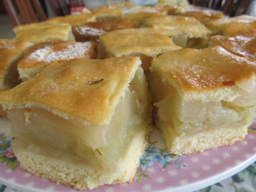

Image Size (w, h):  512 , 512


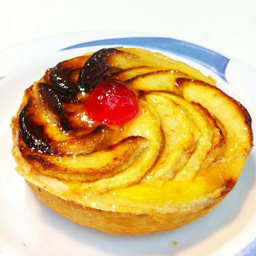

In [42]:
images = list(DATA_DIR.glob(f'{class1}/*'))

for image_path in images[:2]:
    # resize image
    im = Image.open(str(image_path))
    w, h = im.size
    print('Image Size (w, h): ', w, ",",  h)
    percent_resize = 0.5
    im = im.resize((int(w*percent_resize), int(h*percent_resize)))
    display.display(im)

# Setup for Training Model



The ImageDataGenerator is used to create training and validation splits. It also has several builtin image preprocessing transformations.

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [43]:
BATCH_SIZE = 32 * len(gpus)
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

print("Number of classes we are training: " ,len(USE_CLASS_NAMES))
print("\nList of classes")  
list(USE_CLASS_NAMES)[:10]

Number of classes we are training:  101

List of classes


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [45]:
def get_image_data_generator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input ):

    # use image augmentation
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale = 1./255., 
        validation_split=0.2, 
        rotation_range = 40, width_shift_range = 0.2, 
        height_shift_range = 0.2, shear_range = 0.2, 
        zoom_range = 0.2, horizontal_flip = True ,
        preprocessing_function=preprocessing_function
    )
    
      # create a data generator object with options (location of images, batch size, option to shuffle, etc)
    image_data_gen_train = image_generator.flow_from_directory(
          directory=str(DATA_DIR),
          batch_size=BATCH_SIZE,
          shuffle=True,
          target_size=(IMG_HEIGHT, IMG_WIDTH),
          classes = list(USE_CLASS_NAMES) ,
          subset = 'training'
    )
    image_data_gen_validation = image_generator.flow_from_directory(
          directory=str(DATA_DIR),
          batch_size=BATCH_SIZE,
          shuffle=False,
          target_size=(IMG_HEIGHT, IMG_WIDTH),
          classes = list(USE_CLASS_NAMES) ,
          subset = 'validation'
    )
    
    
    return image_data_gen_train,image_data_gen_validation

In [46]:
image_data_gen_train , image_data_gen_validation = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


Found 80814 images belonging to 101 classes.
Found 20202 images belonging to 101 classes.


# Save list of classes

In [47]:
image_data_gen_train.num_classes


101

In [48]:
image_data_gen_train.class_indices.keys()

dict_keys(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons',

In [49]:
list_of_classes = list(image_data_gen_train.class_indices.keys())

In [50]:
list_of_classes[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

In [51]:
with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
    json.dump(list_of_classes, f)

In [52]:
def load_image(path:str) :
    img = Image.open(path)
    img = np.array(img)/255.0
    return img

In [53]:
!ls -lh {DATA_DIR}/{class1}/ | head -6

total 49M
-rw-r--r-- 1 jupyter jupyter  42K Sep 21  2013 1005649.jpg
-rw-r--r-- 1 jupyter jupyter  40K Sep 21  2013 1011328.jpg
-rw-r--r-- 1 jupyter jupyter  34K Sep 21  2013 101251.jpg
-rw-r--r-- 1 jupyter jupyter  47K Sep 21  2013 1014775.jpg
-rw-r--r-- 1 jupyter jupyter  58K Sep 21  2013 1026328.jpg
ls: write error: Broken pipe


In [54]:
#load_image(f"{data_dir}/{class1}/1005649.jpg").shape

In [55]:
#plt.imshow(load_image(f"{data_dir}/{class1}/1005649.jpg"))

In [56]:
#?plt.imshow

In [57]:
#?tf.keras.utils.normalize

In [58]:
# does some pre-processing (built into image generator)
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        print(im.size)

        plt.imshow(image_batch[n]) # norm=(-1,1)
        plt.title(USE_CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [59]:
# ! this code not working  (ask Nidhin)

image_batch, label_batch = next(image_data_gen_train)
#show_batch(image_batch, label_batch)


# Model Architectures

In [60]:
# Open a strategy scope and create/restore the model.
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2021-10-09 17:10:35.333949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:10:35.334888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-10-09 17:10:35.335016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 17:10:35.335827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:00:05.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-10-09 1

### Model 1: VGG19

In [61]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)


def get_model_vgg():
    # Use VGG19 pretrained on ImageNet
    base_layers = tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )

    # Add new layers to be finetuned
    # The last layer, is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
    clf = tf.keras.Sequential([
        base_layers
        , tf.keras.layers.GlobalAveragePooling2D()
        , tf.keras.layers.Dense(1024, activation='relu')
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(image_data_gen_train.num_classes, name='classification', activation='softmax')
    ])
    
    return clf

In [62]:
with strategy.scope():
    clf = get_model_vgg()
    

clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 20,653,221
Trainable params: 20,653,221
Non-trainable params: 0
_________________________________________________________________


In [67]:
# freezes the base layers
clf.layers[0].trainable = False

In [68]:
# notice that after freezing the base layers, the non trainable params are equal to the number of parameters in the base layer 
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 20,653,221
Trainable params: 628,837
Non-trainable params: 20,024,384
_________________________________________________________________


In [69]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_VGG19.log"))
     ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1)
]

In [70]:
# Set the model to use Adam optimizer , cross entropy loss, and track accuracy.
# Since the dataset has multiple classes, we are using cross entropy loss.
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy' ,
  metrics=['accuracy'])

In [71]:
# train the model for 5 epochs
#%%time
image_data_gen_train , image_data_gen_validation = get_image_data_generator (preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
history = clf.fit(image_data_gen_train
                        ,epochs=5
                        ,workers=8 
                        ,callbacks=callbacks
                        ,validation_data=image_data_gen_validation
                        )

Found 80814 images belonging to 101 classes.
Found 20202 images belonging to 101 classes.
Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to

2021-10-09 17:14:00.937589: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2021-10-09 17:14:03.828971: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.8


632/632 [==============================] - ETA: 0s - loss: 3.1921 - accuracy: 0.2740INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
632/632 [==============================] - 273s 431ms/step - loss: 3.1921 - accuracy: 0.2740 - val_loss: 2.2864 - val_accuracy: 0.4378
Epoch 2/5
632/632 [==============================] - 266s 421ms/step - loss: 2.5395 - accuracy: 0.3783 - val_loss: 2.1212 - val_accuracy: 0.4680
Epoch 3/5
632/632 [==============================] - 268s 424ms/step - loss: 2.4278 - accuracy: 0.4021 - val_loss: 2.0607 - val_accuracy: 0.4830
Epoch 4/5
632/632 [==============================] - 269s 425ms/step - loss: 2.3663 - accuracy: 0.4134 - val_loss: 2.0511 - val_accuracy: 0.4878
Epoch 5/5
632/632 [==============================] - 271s 429ms/st

In [72]:
export_path = str(PROJECT_NAME)+"/artifacts/model_VGG19.h5"
export_path
clf.save(export_path, save_format='h5')

### Model 2:  ResNet50

In [73]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)


def get_resnet_50():
    base_layers = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=IMAGE_SHAPE+(3,) )

    model = tf.keras.Sequential([
        base_layers    
        , tf.keras.layers.GlobalAveragePooling2D()
        , tf.keras.layers.Dense(1024, activation='relu')
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(image_data_gen_train.num_classes, name='classification', activation='softmax')


    ])
    
    return model

In [74]:
with strategy.scope():
    clf = get_resnet_50()



In [75]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 25,789,413
Trainable params: 25,736,293
Non-trainable params: 53,120
_________________________________________________________________


In [76]:
clf.layers[0].trainable = False


In [77]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 25,789,413
Trainable params: 2,201,701
Non-trainable params: 23,587,712
_________________________________________________________________


In [78]:
#?tf.keras.optimizers.Adam

In [79]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['accuracy'])

In [80]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_ResNet50.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1)
]

#### Model results

In [81]:
%%time
image_data_gen_train , image_data_gen_validation  = get_image_data_generator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

history = clf.fit(image_data_gen_train
                        ,epochs=5
                        ,workers=8 
                        ,callbacks=callbacks
                        ,validation_data=image_data_gen_validation
                 )
                    

Found 80814 images belonging to 101 classes.
Found 20202 images belonging to 101 classes.
Epoch 1/5
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
632/632 [==============================] - 268s 424ms/step - loss: 2.6707 - accuracy: 0.3526 - val_loss: 1.9857 - val_accuracy: 0.4957
Epoch 2/5
632/632 [==============================] - 262s 414ms/step - loss: 2.1459 - accuracy: 0.4552 - val_loss: 1.7957 - val_accuracy: 0.5403
Epoch 3/5
632/632 [==============================] - 258s 408ms/step - loss: 2.0341 - accuracy: 0.4819 - val_loss: 1.7345 - val_accuracy: 0.5566
Epoch 4/5
632/632 [==============================] - 260s 412ms/step - loss: 1.9748 - accuracy: 0.4928 - val_loss: 1.7225 - val_accuracy: 0.5572
Epoch 5/5
632/632 [==============================] - 263s 417ms/step - loss: 1.9198 - accuracy: 0.5072 - val_loss: 1.6776 - val_accuracy: 0.5712
CPU times: user

#### Save model

In [82]:
export_path = str(PROJECT_NAME)+"/artifacts/model_ResNet50.h5"
export_path
clf.save(export_path, save_format='h5')

## Model 3: MobileNetV2 

In [86]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

def get_mobile_net_v2():
    base_layer = tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )
    
    model = tf.keras.Sequential([
        #hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,) , name='pretrained')
        base_layer
        , tf.keras.layers.GlobalAveragePooling2D()
        , tf.keras.layers.Dense(1024, activation='relu')

        ,tf.keras.layers.Dense(image_data_gen_train.num_classes , name='classification', activation='softmax')

    ])
    return model

In [87]:
with strategy.scope():
    clf = get_mobile_net_v2()
    


In [88]:
clf.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 3,639,141
Non-trainable params: 34,112
_________________________________________________________________


In [89]:
# keep base network layers frozen
clf.layers[0].trainable = False


In [90]:
clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 1,415,269
Non-trainable params: 2,257,984
_________________________________________________________________


In [91]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['accuracy'])

In [92]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_MobileNetV2.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1,restore_best_weights = False)
]



#### Model results

In [93]:
%%time
image_data_gen_train , image_data_gen_validation = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

history = clf.fit(image_data_gen_train
                  ,epochs=5
                  ,workers=8 
                  ,callbacks=callbacks
                  ,validation_data=image_data_gen_validation
                  )

Found 80814 images belonging to 101 classes.
Found 20202 images belonging to 101 classes.
Epoch 1/5
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
632/632 [==============================] - 257s 407ms/step - loss: 2.2146 - accuracy: 0.4496 - val_loss: 1.9490 - val_accuracy: 0.5070
Epoch 2/5
632/632 [==============================] - 254s 401ms/step - loss: 1.8109 - accuracy: 0.5333 - val_loss: 1.8719 - val_accuracy: 0.5222
Epoch 3/5
632/632 [==============================] - 253s 400ms/step - loss: 1.6986 - accuracy: 0.5563 - val_loss: 1.8750 - val_accuracy: 0.5223
Epoch 4/5
632/632 [==============================] - 254s 402ms/step - loss: 1.6180 - accuracy: 0.5734 - val_loss: 1.8218 - val_accuracy: 0.5372
Epoch 5/5
632/632 [==============================] - 252s 398ms/step - loss: 1.5508 - accuracy: 0.5885 - val_loss: 1.8155 - val_accuracy: 0.5376
CPU times: user

#### Save model

In [94]:
# with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
#   json.dump(USE_CLASS_NAMES, f)

In [95]:
export_path = str(PROJECT_NAME)+"/artifacts/model_MobileNetV2.h5"
export_path
clf.save(export_path, save_format='h5')

#clf.save(export_path, save_format='tf')


## Model 3: MobileNetV2 (fine-tuned)

https://www.tensorflow.org/guide/keras/transfer_learning

In [96]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

with strategy.scope():
    clf = get_mobile_net_v2()
    


In [97]:
clf.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 3,639,141
Non-trainable params: 34,112
_________________________________________________________________


In [98]:
clf.layers[0].trainable = False


In [99]:
clf.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 1,415,269
Non-trainable params: 2,257,984
_________________________________________________________________


In [100]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['accuracy'])

In [101]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_MobileNetV2.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1,restore_best_weights = False)
]

#### epochs = 9 
- increase batch size until accuracy decreases
- then rerun from beginning using epoch size where max accuracy was observed

#### Model results

In [102]:
%%time
# changed epochs=3 to epochs=9
image_data_gen_train , image_data_gen_validation = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

history = clf.fit(image_data_gen_train
                  ,validation_data=image_data_gen_validation
                        ,epochs=5
                        ,workers=8 
                        ,callbacks=callbacks
                        )

Found 80814 images belonging to 101 classes.
Found 20202 images belonging to 101 classes.
Epoch 1/5
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
632/632 [==============================] - 259s 409ms/step - loss: 2.2295 - accuracy: 0.4473 - val_loss: 1.9525 - val_accuracy: 0.5048
Epoch 2/5
632/632 [==============================] - 255s 403ms/step - loss: 1.8187 - accuracy: 0.5314 - val_loss: 1.8685 - val_accuracy: 0.5238
Epoch 3/5
632/632 [==============================] - 256s 405ms/step - loss: 1.6994 - accuracy: 0.5578 - val_loss: 1.8350 - val_accuracy: 0.5329
Epoch 4/5
632/632 [==============================] - 255s 404ms/step - loss: 1.6097 - accuracy: 0.5756 - val_loss: 1.8055 - val_accuracy: 0.5380
Epoch 5/5
632/632 [==============================] - 255s 403ms/step - loss: 1.5506 - accuracy: 0.5908 - val_loss: 1.8069 - val_accuracy: 0.5478
CPU times: user

In [103]:
# unfreeze first layer
clf.layers[0].trainable = True
clf.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 3,639,141
Non-trainable params: 34,112
_________________________________________________________________


In [104]:
base_learning_rate=0.001

clf.compile(
  optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['accuracy'])

In [105]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_MobileNetV2_ft2.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1,restore_best_weights = False)
]

#### Model results

In [106]:
%%time

history = clf.fit(image_data_gen_train
                   ,validation_data=image_data_gen_validation
                        ,epochs=5
                        ,workers=8 
                        ,callbacks=callbacks
                        )

Found 80814 images belonging to 101 classes.
Found 20202 images belonging to 101 classes.
Epoch 1/5
INFO:tensorflow:batch_all_reduce: 160 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 160 all-reduces with algorithm = nccl, num_packs = 1
632/632 [==============================] - 286s 453ms/step - loss: 1.5090 - accuracy: 0.6016 - val_loss: 2.1701 - val_accuracy: 0.5061
Epoch 2/5
632/632 [==============================] - 276s 437ms/step - loss: 1.1614 - accuracy: 0.6854 - val_loss: 1.8666 - val_accuracy: 0.5708
Epoch 3/5
632/632 [==============================] - 278s 440ms/step - loss: 1.0287 - accuracy: 0.7195 - val_loss: 1.4875 - val_accuracy: 0.6432
Epoch 4/5
632/632 [==============================] - 279s 441ms/step - loss: 0.9288 - accuracy: 0.7437 - val_loss: 1.4206 - val_accuracy: 0.6545
Epoch 5/5
632/632 [==============================] - 276s 437ms/step - loss: 0.8478 - accuracy: 0.7628 - val_loss: 1.3831 - val_accuracy: 0.6610
CPU times: 

#### Save model

In [107]:
export_path = str(PROJECT_NAME)+"/artifacts/model_MobileNetV2_ft.h5"
export_path
clf.save(export_path, save_format='h5')

In [108]:
clf_final = clf 

In [109]:
list_of_classes = list(image_data_gen_train.class_indices.keys())
with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
    json.dump(list(image_data_gen_train.class_indices.keys()) , f)

# Time to Train

In [110]:
now2 = datetime.now()

end_time = now2.strftime("%H:%M:%S")
print("End Time =", end_time)

End Time = 19:14:52


In [111]:
diff2=((now2-now1).total_seconds() )/ (60)
print("Time to run (minutes): ", diff2)

Time to run (minutes):  125.46438256666667


# Get Model Size

In [112]:
! du -h {PROJECT_NAME}/artifacts

253M	project_food_dl/artifacts


In [113]:
!ls {PROJECT_NAME}/artifacts/ -lah

total 253M
drwxr-xr-x 2 jupyter jupyter 4.0K Oct  9 19:14 .
drwxr-xr-x 5 jupyter jupyter 4.0K Oct  9 17:09 ..
-rw-r--r-- 1 jupyter jupyter 1.5K Oct  9 19:14 classes.json
-rw-r--r-- 1 jupyter jupyter  26M Oct  9 18:27 model_MobileNetV2.h5
-rw-r--r-- 1 jupyter jupyter  29M Oct  9 19:14 model_MobileNetV2_ft.h5
-rw-r--r-- 1 jupyter jupyter 116M Oct  9 17:59 model_ResNet50.h5
-rw-r--r-- 1 jupyter jupyter  84M Oct  9 17:36 model_VGG19.h5
-rw-r--r-- 1 jupyter jupyter  432 Oct  9 18:50 training_MobileNetV2.log
-rw-r--r-- 1 jupyter jupyter  429 Oct  9 19:14 training_MobileNetV2_ft2.log
-rw-r--r-- 1 jupyter jupyter  438 Oct  9 17:59 training_ResNet50.log
-rw-r--r-- 1 jupyter jupyter  429 Oct  9 17:36 training_VGG19.log


# Compare Models

- Dataset:  Food
- Classes: 101
- Total images: 101000
- Batch size: 32

| Model  | Trainable Params| Non-trainable Params | Time (hh:mm:ss) [a]| Accuracy | Epochs | Model Size [b]
|---|---:|---:|---:|---:| ---:|---:|
| VGG19| 628,837   | 20,024,384 | 00:22:50 | 50.1% | 5 | 84M
| ResNet50   | 2,201,701   | 23,587,712 |  00:22:26 | 57.2% | 5 | 116M
| MobileNetV2  | 1,415,269  | 2,257,984 |   00:21:42 | 53.7% | 5 | 26M
| MobileNetV2_ft [c]  | 3,639,141  | 34,112 | 00:45:00   | 66.1% | 10 | 29M

NOTES:  
- [a] If wall clock time < CPU time, then you're executing a program in parallel.
- [b] model size is size of output file
- [c] ft = fine-tuned; time 11min ; 24min; epochs 5+5; model trained on 4 nvidia-t4


---

# Download Assets
#### download MobileNetV2 model

In [114]:
!zip -r {PROJECT_NAME}/artifacts/artifacts.zip {PROJECT_NAME}/artifacts/

  adding: project_food_dl/artifacts/ (stored 0%)
  adding: project_food_dl/artifacts/training_MobileNetV2.log (deflated 43%)
  adding: project_food_dl/artifacts/training_ResNet50.log (deflated 43%)
  adding: project_food_dl/artifacts/model_VGG19.h5 (deflated 8%)
  adding: project_food_dl/artifacts/model_MobileNetV2_ft.h5 (deflated 13%)
  adding: project_food_dl/artifacts/training_VGG19.log (deflated 43%)
  adding: project_food_dl/artifacts/training_MobileNetV2_ft2.log (deflated 42%)
  adding: project_food_dl/artifacts/model_ResNet50.h5 (deflated 11%)
  adding: project_food_dl/artifacts/classes.json (deflated 56%)
  adding: project_food_dl/artifacts/model_MobileNetV2.h5 (deflated 10%)


In [115]:
#from google.colab import files
#files.download(str(str(PROJECT_NAME)+"/artifacts/artifacts.zip"))

# Model Prediction

In [116]:
# if you want to delete a directory from past runs
!rm -rf {PROJECT_NAME}/test_image

In [117]:
# create a sub-directory for data
!mkdir -p {PROJECT_NAME}/test_image

In [118]:
!wget https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg -P {PROJECT_NAME}/test_image -O {PROJECT_NAME}/test_image/black_square.jpg

--2021-10-09 19:15:17--  https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5450 (5.3K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/black_square.jpg’

black_square.jpg    100%[===================>]   5.32K  --.-KB/s    in 0s      

2021-10-09 19:15:17 (341 MB/s) - ‘project_food_dl/test_image/black_square.jpg’ saved [5450/5450]



In [119]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Solanum_melongena_24_08_2012_%281%29.JPG/1280px-Solanum_melongena_24_08_2012_%281%29.JPG  -P {PROJECT_NAME}/test_image -O {PROJECT_NAME}/test_image/eggplant.jpg

--2021-10-09 19:15:18--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Solanum_melongena_24_08_2012_%281%29.JPG/1280px-Solanum_melongena_24_08_2012_%281%29.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 387048 (378K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/eggplant.jpg’

eggplant.jpg        100%[===================>] 377.98K  1.26MB/s    in 0.3s    

2021-10-09 19:15:18 (1.26 MB/s) - ‘project_food_dl/test_image/eggplant.jpg’ saved [387048/387048]



In [120]:
# 
! wget https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg -P {PROJECT_NAME}/test_image  -O {PROJECT_NAME}/test_image/table.jpg


--2021-10-09 19:15:19--  https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 13.225.50.61, 13.225.50.43, 13.225.50.25, ...
Connecting to image.shutterstock.com (image.shutterstock.com)|13.225.50.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11954 (12K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/table.jpg’

table.jpg           100%[===================>]  11.67K  --.-KB/s    in 0.001s  

2021-10-09 19:15:19 (8.44 MB/s) - ‘project_food_dl/test_image/table.jpg’ saved [11954/11954]



In [121]:
! wget https://upload.wikimedia.org/wikipedia/commons/6/61/Small_apple_pie_8.jpg -P {PROJECT_NAME}/test_image  -O {PROJECT_NAME}/test_image/apple_pie.jpg



--2021-10-09 19:15:19--  https://upload.wikimedia.org/wikipedia/commons/6/61/Small_apple_pie_8.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6127171 (5.8M) [image/jpeg]
Saving to: ‘project_food_dl/test_image/apple_pie.jpg’

apple_pie.jpg       100%[===================>]   5.84M  6.07MB/s    in 1.0s    

2021-10-09 19:15:20 (6.07 MB/s) - ‘project_food_dl/test_image/apple_pie.jpg’ saved [6127171/6127171]



In [122]:
! wget https://italianmeddiet.com/wp-content/uploads/Baklava-0470-575x262.jpg -P {PROJECT_NAME}/test_image  -O {PROJECT_NAME}/test_image/baklava.jpg


--2021-10-09 19:15:21--  https://italianmeddiet.com/wp-content/uploads/Baklava-0470-575x262.jpg
Resolving italianmeddiet.com (italianmeddiet.com)... 74.208.236.143
Connecting to italianmeddiet.com (italianmeddiet.com)|74.208.236.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27481 (27K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/baklava.jpg’

baklava.jpg         100%[===================>]  26.84K  --.-KB/s    in 0.04s   

2021-10-09 19:15:21 (600 KB/s) - ‘project_food_dl/test_image/baklava.jpg’ saved [27481/27481]



In [123]:
img_path = f"{PROJECT_NAME}/test_image/eggplant.jpg" # not in dataset
img_path = f"{PROJECT_NAME}/test_image/table.jpg"
img_path = f"{PROJECT_NAME}/test_image/black_square.jpg"
img_path = f"{PROJECT_NAME}/test_image/apple_pie.jpg"
img_path = f"{PROJECT_NAME}/test_image/baklava.jpg"


img_path

'project_food_dl/test_image/baklava.jpg'

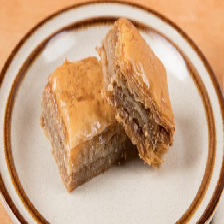

In [124]:
tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))


In [125]:
def load_img_predict(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = np.expand_dims(img, axis = 0)
    
    return img

In [126]:
#classifier = classifier['MobileNetV2']
#classifier = classifier['VGG19']
clf_final.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 3,639,141
Non-trainable params: 34,112
_________________________________________________________________


In [127]:
def predict_image(img_path,classifier):
    img = load_img_predict(img_path)
    res = classifier.predict(img)

    res = sorted (
        list(zip ( 
            list(image_data_gen_train.class_indices.keys())
            , np.squeeze(res)
         )
        )
     , key=lambda x: x[1]   
     , reverse=True
    )
    
    return res

In [128]:
predict_image(img_path,clf_final)[:15]

[('baklava', 0.99872583),
 ('apple_pie', 0.0010666575),
 ('foie_gras', 7.37519e-05),
 ('carrot_cake', 4.3259242e-05),
 ('chocolate_cake', 3.8753005e-05),
 ('chocolate_mousse', 2.1380165e-05),
 ('bread_pudding', 1.7719083e-05),
 ('cheesecake', 9.185784e-06),
 ('panna_cotta', 9.310257e-07),
 ('ice_cream', 5.3325647e-07),
 ('cannoli', 5.178747e-07),
 ('tiramisu', 4.030505e-07),
 ('churros', 2.0866797e-07),
 ('peking_duck', 1.6905604e-07),
 ('cheese_plate', 1.486482e-07)]

In [129]:
now_end = datetime.now()

end_notebook_time = now_end.strftime("%H:%M:%S")
print("End Notebook Time=", end_notebook_time)

diff2=((now_end - now1).total_seconds() )/ (60)
print("Time to run this notebook (minutes): ", diff2)


End Notebook Time= 19:15:26
Time to run this notebook (minutes):  126.03302431666665


In [130]:
print("Number of classes used in dataset:", subset)

Number of classes used in dataset: 102
